## Vol d'hélicoptère

Ce notebook montre quelques algorithmes d'apprentissage par renforcement appliqués à un vol d'hélicoptère en 2D (distance, altitude) :
* Value Iteration
* Policy Iteration
* SARSA
* Q-learning

Une pénalisation peut être appliquée pour un vol à basse altitude.

Votre mission est de tester les différents algorithmes et leurs paramètres, puis d'implémenter l'algorithme Q($\lambda$) utilisant la trace des trajectoires, avec un paramètre de trace $\lambda \in [0,1]$.

## Init

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [226]:
HEIGHT = 10
WIDTH = 20

In [227]:
BEST_REWARD = 100
WORST_REWARD = -100

In [228]:
def get_reward(state, high_altitude = 5, high_alt_cost = 1, low_alt_cost = 10):
    reward = 0
    if state[0] < 0:
        if state[1] == WIDTH - 1:
            # arrival
            reward = BEST_REWARD
        else: 
            # crash
            reward = WORST_REWARD
    elif state[0] < high_altitude:
        # penalize low altitude
        reward = -low_alt_cost
    else:
        reward = -high_alt_cost
    return reward

In [229]:
#actions = [(1,0), (-1,0), (0,1), (0,-1)]
actions = [(1,0), (-1,0), (0,1), (0,-1), (1,1), (-1,-1), (1,-1), (-1,1)]

In [230]:
states = [(i,j) for i in range(HEIGHT) for j in range(WIDTH)]

In [231]:
def valid_state(state):
    return (state[0] >=0) and (state[0] < HEIGHT) and (state[1] >=0) and (state[1] < WIDTH) 

In [232]:
def terminal_state(state):
    return (state[0] < 0)

In [233]:
def move(state, action):
    return tuple(np.array(state) + np.array(action))

In [234]:
def valid_action(state, action):
    new_state = move(state, action)
    return valid_state(new_state) or terminal_state(new_state)

## Value iteration

In [302]:
def show_value(V, cmap = "jet", scale = 20):
    max_dimension = max(HEIGHT, WIDTH)
    plt.figure(figsize=(scale * HEIGHT / max_dimension,scale * WIDTH / max_dimension))
    plt.imshow(np.flip(V, axis = 0), cmap, vmin = WORST_REWARD, vmax = BEST_REWARD)
    plt.axis('off')
    plt.show()

In [303]:
def value_iteration_synchronous(gamma, tol, max_iter):
    '''
    gamma: float
        discount factor
    tol: float
        tolerance for convergence
    max_iter: float
        max number of iterations
    '''
    # Randomly initialize V
    V = np.zeros((HEIGHT, WIDTH))
    error = np.inf
    iteration = 0
    
    while error > tol:

        new_V = np.zeros((HEIGHT, WIDTH))
        for state in states:
            max_value = np.NINF
            for action in actions:
                
                #Move with action
                new_state = move(state, action)
                
                # Get reward
                if valid_state(new_state):
                    value = get_reward(new_state) + gamma * V[new_state]
                
                # Get reward
                elif terminal_state(new_state):
                    value = get_reward(new_state)
                
                
                else:
                    value = np.NINF
                
                if value > max_value:
                    max_value = value
            
            new_V[state] = max_value
        
        error = np.max(np.abs(new_V - V))
        V = new_V
        iteration += 1
        
        if iteration >= max_iter:
            break
    
    return V

In [304]:
def value_iteration_asynchronous(gamma, tol, max_iter):
    '''
    gamma: float
        discount factor
    tol: float
        tolerance for convergence
    max_iter: float
        max number of iterations
    '''
    V = np.zeros((HEIGHT, WIDTH))
    error = np.inf
    iteration = 0
    
    while error > tol:
        
        error = 0
        
        for state in states:
            max_value = np.NINF
            
            for action in actions:
                new_state = move(state, action)
                
                if valid_state(new_state):
                    value = get_reward(new_state) + gamma * V[new_state]
                
                elif terminal_state(new_state):
                    value = get_reward(new_state)
                
                else:
                    value = np.NINF
                
                if value > max_value:
                    max_value = value
            
            error_ = np.abs(max_value - V[state])
            
            # if error_ < error:
            if error_ > error:
                error = error_
            
            # Update V directly
            V[state] = max_value
        
        iteration += 1
        
        if iteration >= max_iter:
            break
    
    return V

In [305]:
def value_iteration(asynchronous = True, gamma = 1, tol = 1e-10, max_iter = 50):
    '''
    asynchronous: bool
        if True, asynchronous updates
    gamma: float
        discount factor
    tol: float
        tolerance for convergence
    max_iter: float
        max number of iterations
    '''
    if asynchronous:
        return value_iteration_asynchronous(gamma, tol, max_iter)
    else:
        return value_iteration_synchronous(gamma, tol, max_iter)

In [306]:
V = np.zeros((HEIGHT, WIDTH))

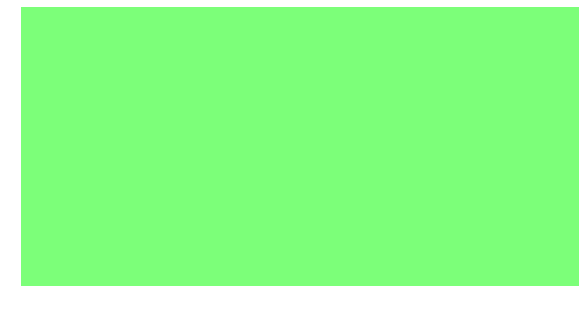

In [307]:
show_value(V)

### Asynchronous 

In [310]:
V = value_iteration(max_iter=300, asynchronous=True)

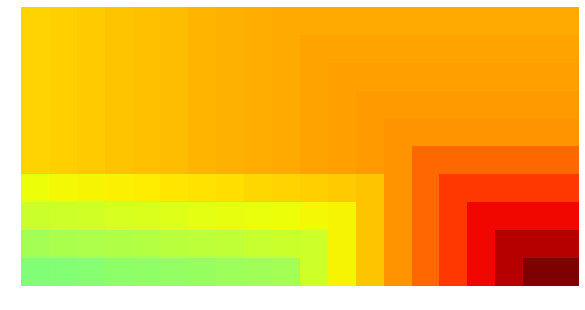

In [312]:
show_value(V)

### Synchronous 

In [313]:
V = value_iteration(max_iter=30, asynchronous=False)

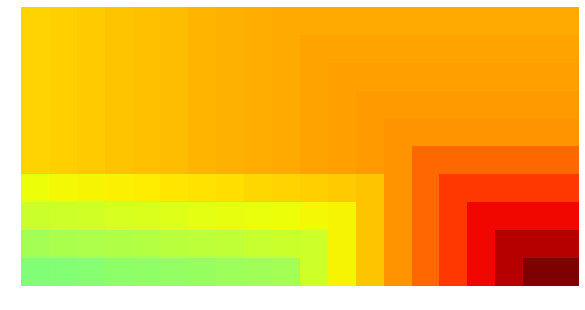

In [314]:
show_value(V)

### Show path

In [315]:
def best_policy(V, gamma = 1):
    
    # Fill this matrix with best policy
    policy = np.zeros((HEIGHT, WIDTH), dtype=tuple)
    
    # For each state
    for state in states:
        
        max_value = np.NINF
        
        for action in actions:
            new_state = move(state, action)
            
            if valid_state(new_state):
                value = get_reward(new_state) + gamma * V[new_state]
            
            elif terminal_state(new_state):
                value = get_reward(new_state)
            
            else:
                value = np.NINF
            
            if value > max_value:
                max_value = value
                best_action = action
        
        # Update the policy state
        policy[state] = best_action
    
    return policy

In [317]:
policy = best_policy(V)

In [319]:
def get_path(policy, state = (0, 0)):
    path = []
    while not(terminal_state(state)) and state not in path:
        path.append(state)
        action = policy[state]
        state = move(state, action)
    return path

In [320]:
path = get_path(policy)

In [321]:
def show_path(path, scale = 20, cmap = "Greys"):
    max_dimension = max(HEIGHT, WIDTH)
    plt.figure(figsize=(scale * HEIGHT / max_dimension,scale * WIDTH / max_dimension))
    P = np.zeros((HEIGHT, WIDTH))
    for i,j in path:
        P[i,j] = 1
    plt.imshow(np.flip(P, axis = 0),cmap, vmin = 0, vmax = 1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()

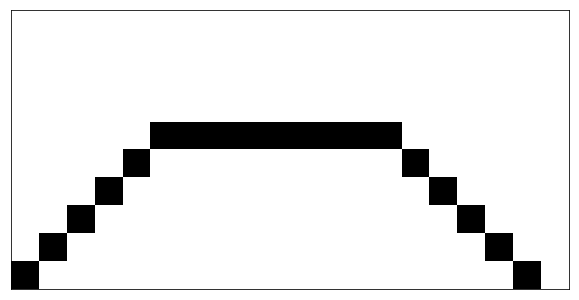

In [322]:
show_path(path)

## Policy iteration

In [358]:
def init_random_policy():
    policy = np.zeros((HEIGHT, WIDTH), dtype=tuple)
    for state in states:
        valid_actions = [action for action in actions if valid_action(state, action)]
        policy[state] = valid_actions[np.random.choice(len(valid_actions))]
    return policy

In [359]:
def policy_evaluation_synchronous(policy, gamma, tol, max_iter):
    '''
    gamma: float
        discount factor
    tol: float
        tolerance for convergence
    max_iter: float
        max number of iterations
    '''
    V = np.zeros((HEIGHT, WIDTH))
    error = np.inf
    iteration = 0
    while error > tol:
        new_V = np.zeros((HEIGHT, WIDTH))
        for state in states:
            action = policy[state]
            new_state = move(state, action)
            if valid_state(new_state):
                value = get_reward(new_state) + gamma * V[new_state]
            elif terminal_state(new_state):
                value = get_reward(new_state)
            new_V[state] = value
        error = np.max(np.abs(new_V - V))
        V = new_V
        iteration += 1
        if iteration >= max_iter:
            break
    return V

In [360]:
def policy_evaluation_asynchronous(policy, gamma, tol, max_iter):
    '''
    gamma: float
        discount factor
    tol: float
        tolerance for convergence
    max_iter: float
        max number of iterations
    '''
    V = np.zeros((HEIGHT, WIDTH))
    error = np.inf
    iteration = 0
    while error > tol:
        for state in states:
            action = policy[state]
            new_state = move(state, action)
            if valid_state(new_state):
                value = get_reward(new_state) + gamma * V[new_state]
            elif terminal_state(new_state):
                value = get_reward(new_state)
            error_ = np.abs(value - V[state])
            if error_ > error:
                error = error_
            V[state] = value
        iteration += 1
        if iteration >= max_iter:
            break
    return V

In [361]:
def policy_evaluation(policy, asynchronous = True, gamma = 1, tol = 1e-2, max_iter = 100):
    '''
    asynchronous: bool
        if True, asynchronous updates
    gamma: float
        discount factor
    tol: float
        tolerance for convergence
    max_iter: float
        max number of iterations
    '''
    if asynchronous:
        return policy_evaluation_asynchronous(policy, gamma, tol, max_iter)
    else:
        return policy_evaluation_synchronous(policy, gamma, tol, max_iter)

In [362]:
policy = init_random_policy()

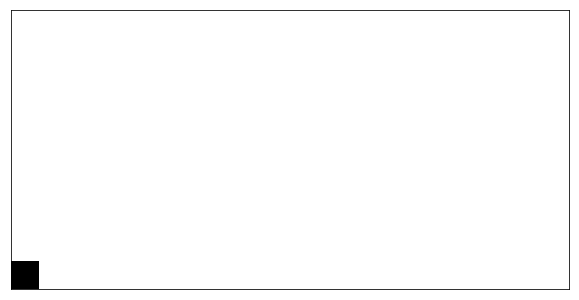

In [363]:
show_path(get_path(policy))

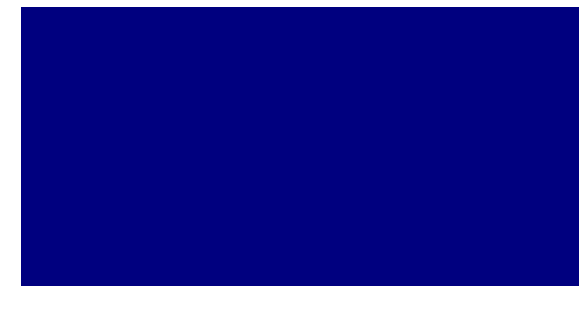

In [364]:
V = policy_evaluation(policy)
show_value(V)

In [365]:
policy = best_policy(V)

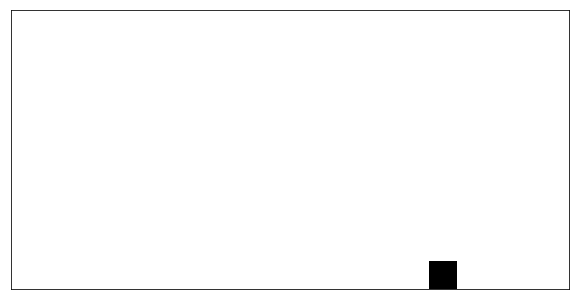

In [366]:
show_path(get_path(policy, state = (0,15)))

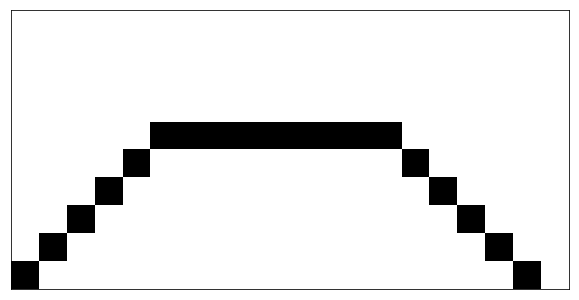

In [367]:
# Policy iteration
for i in range(20):
    V = policy_evaluation(policy)
    policy = best_policy(V)
    
show_path(get_path(policy))

## SARSA

Online learning. On-policy (behaviour = target).

In [368]:
state_actions = [(state, action) for state in states for action in actions
                 if valid_action(state, action)]

In [369]:
Q = {(state, action): 0 for (state, action) in state_actions}

In [370]:
def get_action(state, policy, eps = 0.1):
    '''
    eps: float
        Parameter of the epsilon-greedy policy
        Controls the exploration (eps = 0 means no exploration)
    '''
    if np.random.random() < eps:
        valid_actions = [action for action in actions if valid_action(state, action)]
        return valid_actions[np.random.choice(len(valid_actions))]
    else:
        return policy[state]    

In [371]:
def sarsa(alpha = 0.9, gamma = 1, max_sequence = 200, steps = 10000, 
          verbose = True, batch = 10**3):
    policy = init_random_policy()
    Q = {(state, action): 0 for (state, action) in state_actions}
    for t in range(steps):
        if verbose:
            if t%batch == 0:
                print('Batch ',str(t // batch + 1),' over ',str(steps // batch))
        # start an episode
        state = states[np.random.choice(len(states))]
        action = get_action(state, policy)
        sequence = []
        while not(terminal_state(state)) and len(sequence) < max_sequence:
            sequence.append(state)
            new_state = move(state, action)
            reward = get_reward(new_state)
            new_action = get_action(new_state, policy)
            if terminal_state(new_state):
                Q[(state, action)] += alpha * (reward - Q[(state, action)])
            else:
                Q[(state, action)] += alpha * (reward + gamma * Q[(new_state, new_action)] 
                                               - Q[(state, action)])
            state = new_state
            action = new_action
        # update policy
        for state in sequence:
            qvalues = {a: Q[(state, a)] for a in actions if valid_action(state, a)}
            policy[state] = max(qvalues, key = qvalues.get)
    return policy

In [372]:
sarsa_policy = sarsa(gamma = 1)

Batch  1  over  10


IndexError: index 20 is out of bounds for axis 1 with size 20

In [373]:
V = policy_evaluation(sarsa_policy, gamma=0.9)
show_value(V)

NameError: name 'sarsa_policy' is not defined

In [374]:
show_path(get_path(sarsa_policy))

NameError: name 'sarsa_policy' is not defined

## Q-learning

Online learning. Off-policy (behaviour $\ne$ target).

In [351]:
def qlearning(alpha = 0.9, gamma = 1, max_sequence = 100, steps = 10**4, 
              verbose = True, batch = 10**3):
    policy = init_random_policy()
    Q = {(state, action): 0 for (state, action) in state_actions}
    for t in range(steps):
        if verbose:
            if t%batch == 0:
                print('Batch ',str(t // batch + 1),' over ',str(steps // batch))
        # start an episode
        state = states[np.random.choice(len(states))]
        sequence = []
        while not(terminal_state(state)) and len(sequence) < max_sequence:
            sequence.append(state)
            action = get_action(state, policy)
            new_state = move(state, action)
            reward = get_reward(new_state)
            if terminal_state(new_state):
                Q[(state, action)] += alpha * (reward - Q[(state, action)])
            else:
                qvalues = [Q[(new_state, a)] for a in actions if valid_action(new_state, a)]
                Q[(state, action)] += alpha * (reward + gamma * np.max(np.array(qvalues))
                                               - Q[(state, action)]) 
            state = new_state
        # update policy
        for state in sequence:
            qvalues = {a: Q[(state, a)] for a in actions if valid_action(state, a)}
            policy[state] = max(qvalues, key = qvalues.get)
    return policy

In [352]:
qlearning_policy = qlearning(gamma = 0.9)

Batch  1  over  10
Batch  2  over  10
Batch  3  over  10
Batch  4  over  10
Batch  5  over  10
Batch  6  over  10
Batch  7  over  10
Batch  8  over  10
Batch  9  over  10
Batch  10  over  10


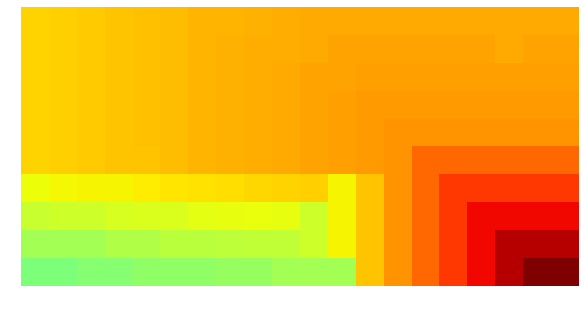

In [353]:
V = policy_evaluation(qlearning_policy)
show_value(V)

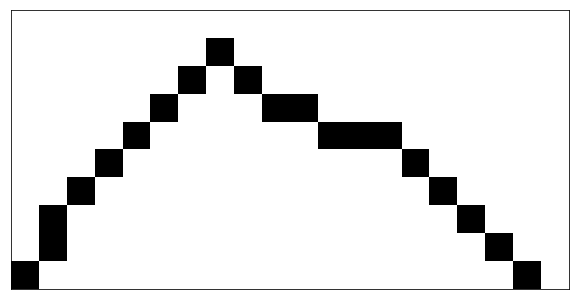

In [354]:
show_path(get_path(qlearning_policy))